In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
from time import time
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import (SVC, LinearSVC)
from sklearn import pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score


from sklearn import decomposition


In [5]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "rb") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])

    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

def plot_learning_curve(estimator, title, X, y, scoring, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes, scoring=scoring,error_score=np.nan)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

# Utility function to report best scores
def report(results, scoring,n_top=3):
    if len(scoring)>1:
        for s in range(len(scoring)):
            for i in range(1, n_top + 1):
                candidates = np.flatnonzero(results['rank_test_'+scoring[s]] == i)
                for candidate in candidates:
                    print("Model with rank: {0}".format(i))
                    print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                          scoring[s],
                          results['mean_test_'+scoring[s]][candidate],
                          results['std_test_'+scoring[s]][candidate]))
                    print("Parameters: {0}".format(results['params'][candidate]))
                    print("")
                    
    else:
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                      scoring[0],
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

In [6]:
#Load in data
trainset = pd.read_csv('trainset_p2.csv', encoding = "ISO-8859-1").iloc[:,1:]
testset= pd.read_csv('testset_p2.csv', encoding = "ISO-8859-1").iloc[:,1:]

In [7]:
# Transform each text into a TF-IDF vector 
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2))
vectorizer.fit(pd.concat([trainset['text'],testset['text']]))

training_features = vectorizer.transform(trainset["text"])    
test_features = vectorizer.transform(testset["text"])

In [5]:
#MLP
n_iter_search = 3
parameters = {'hidden_layer_sizes':[(i,) for i in np.linspace(5,50,num=10).astype(int)], 
              'activation': ['identity','logistic','tanh','relu'], 'solver':['lbfgs','sgd','adam'],
              'alpha':np.linspace(0.00001,0.0002,num=20),'learning_rate':['constant','invscaling','adaptive'],
              'learning_rate_init':np.linspace(0.00001,0.0002,num=20)}

clf_mlp = RandomizedSearchCV(MLPClassifier(max_iter=50000), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

In [9]:
#mlp on SMOTE
start = time()
clf_mlp.fit(training_features, trainset["sentiment"])
print("Multi-layer Perceptron classifier on SMOTE took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_mlp.cv_results_,scoring=['accuracy'])

Model with rank: 1
Mean validation accuracy: 0.865 (std: 0.004)
Parameters: {'learning_rate': 'invscaling', 'solver': 'lbfgs', 'hidden_layer_sizes': (45,), 'activation': 'identity', 'alpha': 2e-05, 'learning_rate_init': 0.00017}

Model with rank: 2
Mean validation accuracy: 0.847 (std: 0.027)
Parameters: {'learning_rate': 'adaptive', 'solver': 'adam', 'hidden_layer_sizes': (5,), 'activation': 'relu', 'alpha': 5e-05, 'learning_rate_init': 0.0002}

Model with rank: 3
Mean validation accuracy: 0.500 (std: 0.000)
Parameters: {'learning_rate': 'constant', 'solver': 'sgd', 'hidden_layer_sizes': (10,), 'activation': 'identity', 'alpha': 1e-05, 'learning_rate_init': 9e-05}



MLPClassifier(activation='identity', alpha=2e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(45,), learning_rate='invscaling',
       learning_rate_init=0.00017, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


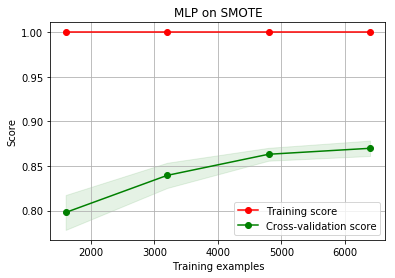

In [10]:
clf_mlp_optim = clf_mlp_optim.best_estimator_
print(clf_mlp_optim)

%matplotlib inline

plot_learning_curve(clf_mlp_optim , "MLP",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_1_Model\clf_mlp_optim.sav'
pickle.dump(clf_mlp_optim, open(filename, 'wb'))

In [17]:
clf_performance = pd.read_csv('model_performance_p2.csv').iloc[:,1:]

In [18]:
start = time()
clf_mlp_optim.fit(training_features, trainset["sentiment"])
print('The training time of mlp is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_mlp_optim.predict(training_features)

y_pred_test = clf_mlp_optim.predict(test_features)

mlp_perf={'classifier':'mlp',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=mlp_perf

The training time of mlp is 1041.928s


In [21]:
clf_mlp_optim.n_iter_

36